--2024-08-27 15:17:53--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip.1’

bike+sharing+datase     [    <=>             ] 273.43K   281KB/s    in 1.0s    

2024-08-27 15:17:54 (281 KB/s) - ‘bike+sharing+dataset.zip.1’ saved [279992]

Archive:  bike+sharing+dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: day.csv                 
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hour.csv                
Linear Regression (Package) - Mean Squared Error: 14974.440654149748
Linear Regression (Package) - R-squared: 0.5271041801718357


<ipython-input-2-4fb0275a2a9e>:81: RuntimeWarning: invalid value encountered in subtract
  self.coef_ -= self.learning_rate * gradients


NaN values detected in predictions from the scratch model.
Random Forest - Mean Squared Error: 1809.080677099262
Random Forest - R-squared: 0.9428688717200888


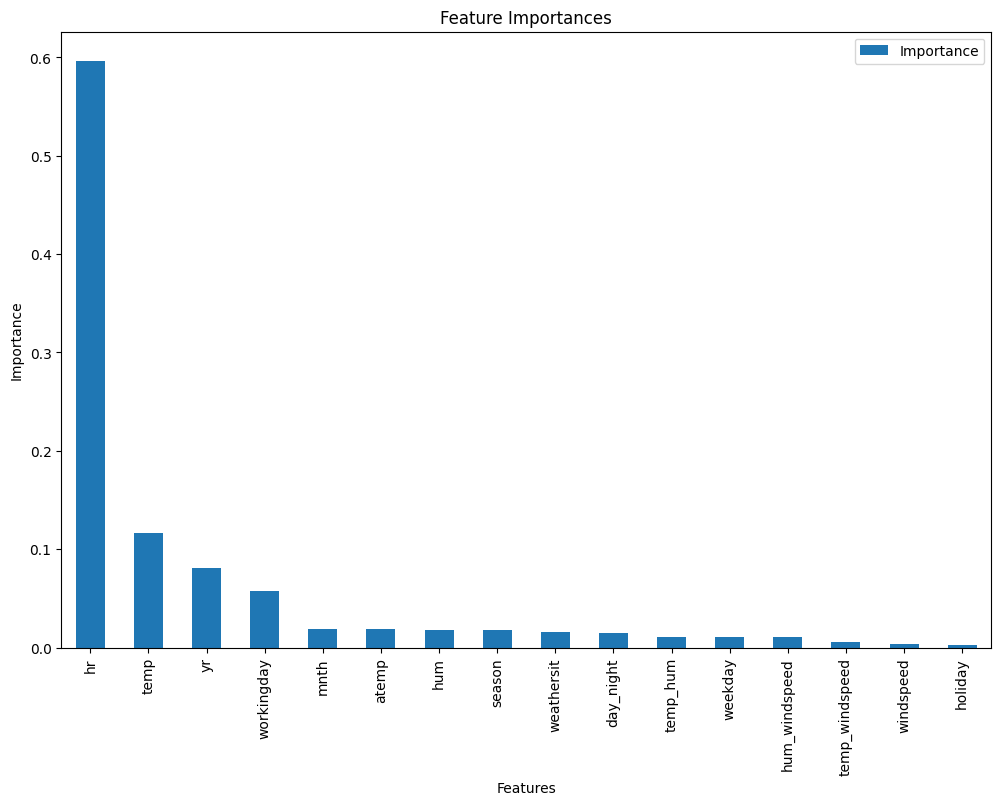

One or more metrics are NaN and will not be logged.


In [ ]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip bike+sharing+dataset.zip
!pip install category_encoders
!pip install mlflow

import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce

import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('hour.csv')
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
df['temp_hum'] = df['temp'] * df['hum']
df['temp_windspeed'] = df['temp'] * df['windspeed']
df['hum_windspeed'] = df['hum'] * df['windspeed']
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)

X = df.drop(columns=['cnt'])
y = df['cnt']

# Numerical pipeline
numerical_features = ['temp', 'hum', 'windspeed', 'temp_hum', 'temp_windspeed', 'hum_windspeed']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])

# Categorical pipeline using TargetEncoder
categorical_features = ['season', 'weathersit', 'day_night']
categorical_pipeline = ce.TargetEncoder(cols=categorical_features)
X_encoded = categorical_pipeline.fit_transform(X[categorical_features], y)
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Train Linear Regression using the package (sklearn)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression (Package) - Mean Squared Error: {mse_lr}')
print(f'Linear Regression (Package) - R-squared: {r2_lr}')

# 2. Train Linear Regression from scratch
class LinearRegressorScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.coef_ = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
        self.coef_ = np.zeros(X_b.shape[1])
        for iteration in range(self.n_iterations):
            predictions = X_b.dot(self.coef_)
            errors = predictions - y
            gradients = 2 / X_b.shape[0] * X_b.T.dot(errors)
            self.coef_ -= self.learning_rate * gradients

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term
        return X_b.dot(self.coef_)

# Train Linear Regression from scratch
lr_scratch_model = LinearRegressorScratch(learning_rate=0.001, n_iterations=1000)
lr_scratch_model.fit(X_train, y_train)
y_pred_lr_scratch = lr_scratch_model.predict(X_test)

# Ensure no NaN values in predictions
if np.any(np.isnan(y_pred_lr_scratch)):
    print("NaN values detected in predictions from the scratch model.")
else:
    mse_lr_scratch = mean_squared_error(y_test, y_pred_lr_scratch)
    r2_lr_scratch = r2_score(y_test, y_pred_lr_scratch)
    print(f'Linear Regression (Scratch) - Mean Squared Error: {mse_lr_scratch}')
    print(f'Linear Regression (Scratch) - R-squared: {r2_lr_scratch}')

# 3. Train Random Forest Regressor for comparison
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - R-squared: {r2_rf}')

# Plot feature importances for Random Forest
import matplotlib.pyplot as plt

feat_importances = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.plot(kind='bar', figsize=(12,8))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Log metrics with MLflow
import mlflow
import mlflow.sklearn

# Log metrics only if they are valid
metrics = {
    "mse_rf": mse_rf,
    "r2_rf": r2_rf,
    "mse_lr": mse_lr,
    "r2_lr": r2_lr,
    "mse_lr_scratch": mse_lr_scratch if 'mse_lr_scratch' in locals() else None,
    "r2_lr_scratch": r2_lr_scratch if 'r2_lr_scratch' in locals() else None
}

# Log only if all metrics are valid
if all(v is not None for v in metrics.values()):
    with mlflow.start_run():
        mlflow.log_param("model", "RandomForestRegressor")
        mlflow.log_param("features", numerical_features + categorical_features)
        mlflow.sklearn.log_model(rf_model, "model")
        mlflow.log_metrics(metrics)
else:
    print("One or more metrics are NaN and will not be logged.")
